# Building and using ion channel models

In this tutorial, you will learn how to:  
- define your own ion channel models beyond the preconfigured channels in `jaxley`

This tutorial assumes that you have already learned how to [build basic simulations of morphologically detailed neurons]().

In [1]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad

import jaxley as jx

First, we define a cell as you saw in the [previous tutorial]():

In [2]:
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=4)
cell = jx.Cell(branch, parents=[-1, 0, 0, 1, 1, 2, 2])

You have also already learned how to insert preconfigured channels into `Jaxley` models:
```python
cell.insert(Na())
cell.insert(K())
cell.insert(Leak())
```

In this tutorial, we will show you how to build your own channel and synapse models.

### Your own channel
Below is how you can define your own channel. We will go into detail about individual parts of the code in the next couple of cells.

In [14]:
import jax.numpy as jnp
from jaxley.channels import Channel
from jaxley.solver_gate import solve_gate_exponential


def exp_update_alpha(x, y):
    return x / (jnp.exp(x / y) - 1.0)

class Potassium(Channel):
    """Potassium channel."""

    def __init__(self, name = None):
        super().__init__(name)
        self.channel_params = {"gK_new": 1e-4}
        self.channel_states = {"n_new": 0.0}
        self.current_name = "i_K"

    def update_states(self, states, dt, v, params):
        """Update state."""
        ns = states["n_new"]
        alpha = 0.01 * exp_update_alpha(-(v + 55), 10)
        beta = 0.125 * jnp.exp(-(v + 65) / 80)
        new_n = solve_gate_exponential(ns, dt, alpha, beta)
        return {"n_new": new_n}

    def compute_current(self, states, v, params):
        """Return current."""
        ns = states["n_new"]
        
        # Multiply with 1000 to convert Siemens to milli Siemens.
        kd_conds = params["gK_new"] * ns**4 * 1000  # mS/cm^2

        e_kd = -77.0        
        return kd_conds * (v - e_kd)

    def init_state(self, v, params):
        alpha = 0.01 * exp_update_alpha(-(v + 55), 10)
        beta = 0.125 * jnp.exp(-(v + 65) / 80)
        return {"n_new": alpha / (alpha + beta)}

Let's look at each part of this in detail. 

The below is simply a helper function for the solver of the gate variables:
```python
def exp_update_alpha(x, y):
    return x / (jnp.exp(x / y) - 1.0)
```

Next, we define our channel as a class. It should inherit from the `Channel` class and define `channel_params`, `channel_states`, and `current_name`.
```python
class Potassium(Channel):
    """Potassium channel."""

    def __init__(self, name=None):
        super().__init__(name)
        self.channel_params = {"gK_new": 1e-4}
        self.channel_states = {"n_new": 0.0}
        self.current_name = "i_K"
```

Next, we have the `update_states()` method, which updates the gating variables:
```python
    def update_states(self, states, dt, v, params):
```

The inputs `states` to the `update_states` method is a dictionary which contains all states that are updated (including states of other channels). `v` is a `jnp.ndarray` which contains the voltage of a single compartment (shape `()`). Let's get the state of the potassium channel which we are building here:
```python
ns = states["n_new"]
```

Next, we update the state of the channel. In this example, we do this with exponential Euler, but you can implement any solver yourself:
```python
alpha = 0.01 * exp_update_alpha(-(v + 55), 10)
beta = 0.125 * jnp.exp(-(v + 65) / 80)
new_n = solve_gate_exponential(ns, dt, alpha, beta)
return {"n_new": new_n}
```

A channel also needs a `compute_current()` method which returns the current throught the channel:
```python
    def compute_current(self, states, v, params):
        ns = states["n_new"]
        
        # Multiply with 1000 to convert Siemens to milli Siemens.
        kd_conds = params["gK_new"] * ns**4 * 1000  # mS/cm^2

        e_kd = -77.0        
        current = kd_conds * (v - e_kd)
        return current
```

Finally, the `init_state()` method can be implemented optionally. It can be used to automatically compute the initial state based on the voltage when `cell.init_states()` is run.

Alright, done! We can now insert this channel into any `jx.Module` such as our cell:

In [4]:
cell.insert(Potassium())

In [5]:
cell.delete_stimuli()
current = jx.step_current(1.0, 1.0, 0.1, 0.025, 10.0)
cell.branch(0).comp(0).stimulate(current)

cell.delete_recordings()
cell.branch(0).comp(0).record()

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.


In [6]:
s = jx.integrate(cell)

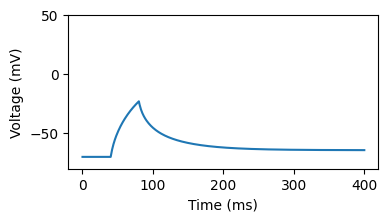

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(s.T[:-1])
_ = ax.set_ylim([-80, 50])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")

### Your own synapse

The parts below assume that you have already learned how to [build network simulations in `Jaxley`]().

The below is an example of how to define your own synapse model in `Jaxley`:`

In [8]:
import jax.numpy as jnp
from jaxley.synapses.synapse import Synapse


class TestSynapse(Synapse):
    """
    Compute syanptic current and update syanpse state.
    """
    def __init__(self, name = None):
        super().__init__(name)
        self.synapse_params = {"gChol": 0.001, "eChol": 0.0}
        self.synapse_states = {"s_chol": 0.1}

    def update_states(self, states, delta_t, pre_voltage, post_voltage, params):
        """Return updated synapse state and current."""
        s_inf = 1.0 / (1.0 + jnp.exp((-35.0 - pre_voltage) / 10.0))
        exp_term = jnp.exp(-delta_t)
        new_s = states["s_chol"] * exp_term + s_inf * (1.0 - exp_term)
        return {"s_chol": new_s}

    def compute_current(self, states, pre_voltage, post_voltage, params):
        g_syn = params["gChol"] * states["s_chol"]
        return g_syn * (post_voltage - params["eChol"])

As you can see above, synapses follow closely how channels are defined. The main difference is that the `compute_current` method takes two voltages: the pre-synaptic voltage (a `jnp.ndarray` of shape `()`) and the post-synaptic voltage (a `jnp.ndarray` of shape `()`).

In [9]:
net = jx.Network([cell for _ in range(3)])

In [10]:
from jaxley.connect import connect

pre = net.cell(0).branch(0).loc(0.0)
post = net.cell(1).branch(0).loc(0.0)
connect(pre, post, TestSynapse())

/Users/michaeldeistler/Documents/phd/jaxley/jaxley/modules/base.py:1533: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.pointer.edges = pd.concat(


In [11]:
net.cell(0).branch(0).loc(0.0).stimulate(jx.step_current(1.0, 2.0, 0.1, 0.025, 10.0))
for i in range(3):
    net.cell(i).branch(0).loc(0.0).record()

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


In [12]:
s = jx.integrate(net)

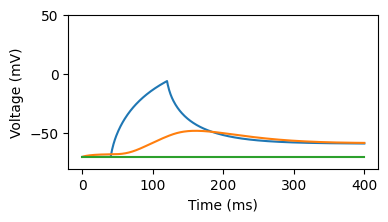

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(s.T[:-1])
_ = ax.set_ylim([-80, 50])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")

That's it! You are now ready to build your own custom simulations and equip them with channel and synapse models!

This tutorial does not have an immediate follow-up tutorial. You could read the [tutorial on groups](), which allow to make your `Jaxley` simulations more elegant and convenient to interact with.

Alternatively, you can also directly jump ahead to the [tutorial on training biophysical networks]() which will teach you how you can optimize parameters of biophysical models with gradient descent.